In [12]:

# Cell 1: Data Retrieval

# We import 3 datasets:
# 1. The NQ contract data
# 2. The Nasdaq 100 instruments
# 3. The OHLCV data for the underlying asset - to display chart

import databento as db
import os
import pandas as pd
import mplfinance as mpf
import numpy as np

api_key = os.environ.get('DATA_BENTO_API_KEY')

# The NQM4 trades between 2023-03-17 and 2024-06-21
# The Nasdaq trades on weekdays from 13:30 to 20:00 UTC
start_time = "2024-05-31T13:30:00"
end_time = "2024-05-31T13:35:00"
# This is the CME Globex market
dataset = 'GLBX.MDP3'
# June E-mini-Nasdaq-100
symbols = ['NQM4']
# This is the NASDAQ market
underlying_dataset = 'XNAS.ITCH'
underlying_symbols = [
    "MSFT", "AAPL", "NVDA", "AMZN", "META", "AVGO", "GOOGL", "COST", "GOOG", "TSLA",
    "AMD", "NFLX", "PEP", "ADBE", "LIN", "CSCO", "TMUS", "QCOM", "INTU", "INTC",
    "CMCSA", "AMAT", "TXN", "AMGN", "ISRG", "HON", "LRCX", "BKNG", "VRTX", "MU",
    "SBUX", "REGN", "ADP", "MDLZ", "ADI", "KLAC", "GILD", "PANW", "SNPS", "PDD",
    "CDNS", "ASML", "MELI", "CRWD", "CSX", "MAR", "ABNB", "PYPL", "ORLY", "CTAS",
    "PCAR", "MNST", "NXPI", "ROP", "WDAY", "LULU", "MRVL", "ADSK", "CEG", "CPRT",
    "DASH", "FTNT", "DXCM", "ROST", "MCHP", "ODFL", "FAST", "PAYX", "IDXX", "AEP",
    "CHTR", "KHC", "GEHC", "KDP", "MRNA", "CSGP", "AZN", "DDOG", "CTSH", "TTD",
    "EXC", "EA", "FANG", "VRSK", "CDW", "BKR", "CCEP", "ON", "BIIB", "TEAM",
    "ANSS", "ZS", "XEL", "GFS", "DLTR", "MDB", "TTWO", "WBD", "ILMN", "WBA", "SIRI"
    ]
# Schema Docs - https://databento.com/docs/knowledge-base/new-users/fields-by-schema
# "Top of Book Bid and Offer"
orders_schema = "tbbo"
# "Open High Low Close Volume - 1 second"
chart_schema = "ohlcv-1s"

# Get historical or live data from Databento
client = db.Historical(api_key)

# Get the data and convert to dataframes
underlying_df = client.timeseries.get_range(
    dataset=underlying_dataset,
    symbols=underlying_symbols,
    schema=orders_schema,
    start=start_time,
    end=end_time,
).to_df()

nq_df = client.timeseries.get_range(
    dataset=dataset,
    symbols=symbols,
    schema=orders_schema,
    start=start_time,
    end=end_time,
).to_df()

nq_ohlc_df = client.timeseries.get_range(
    dataset=dataset,
    schema=chart_schema,
    symbols=symbols,
    start=start_time,
    end=end_time,
).to_df()

2024-06-04 16:49:59,898 - INFO     - Initialized Historical(gateway=https://hist.databento.com)
/tmp/ipykernel_12556/2485137421.py:48: BentoWarning:

The streaming request contained one or more days which have reduced quality: 2024-05-31 (degraded). See: https://databento.com/docs/api-reference-historical/metadata/metadata-get-dataset-condition



In [13]:
# Cell 2: Trade logic
from modify_trades import modify_trades
from calculate_pnl import calculate_pnl

nq_df['nq_ask'] = nq_df['ask_px_00']
nq_df['nq_bid'] = nq_df['bid_px_00']

# Concatenate underlying_df and nq_df, then sort
nq_and_underlying_df = pd.concat([underlying_df, nq_df]).sort_index()

# Forward-fill 'nq_ask' and 'nq_bid' to ensure all rows have the most recent values
nq_and_underlying_df['nq_ask'] = nq_and_underlying_df['nq_ask'].ffill()
nq_and_underlying_df['nq_bid'] = nq_and_underlying_df['nq_bid'].ffill()

# Group by second and aggregate buy/sell counts
grouped_df = nq_and_underlying_df.groupby(nq_and_underlying_df.index.floor('S')).agg(
    underlying_total_sells=('side', lambda x: x.eq('A').sum()),
    underlying_total_buys=('side', lambda x: x.eq('B').sum()),
    nq_ask=('nq_ask', 'last'),
    nq_bid=('nq_bid', 'last')
)

# Create new dataframe to store trades - Note we need to match the index with the ohlcv dataframe
trades_df = pd.DataFrame(index=nq_ohlc_df.index, columns=['price', 'side', 'trade_open', 'trade_pnl'])

# Calculate trade conditions
buy_condition = (grouped_df['underlying_total_sells'] > grouped_df['underlying_total_buys'] * 2)
sell_condition = (grouped_df['underlying_total_buys'] > grouped_df['underlying_total_sells'] * 2)

# If the trade conditions are met, log the trade
trades_df.loc[sell_condition, 'price'] = grouped_df['nq_bid']
trades_df.loc[sell_condition, 'side'] = 'S'
trades_df.loc[buy_condition, 'price'] = grouped_df['nq_ask']
trades_df.loc[buy_condition, 'side'] = 'B'


# Modify the trade dataframe to restrict to 1 contract open at a time
modify_trades(trades_df)
# Add a pnl and total_pnl column to the trades dataframe
calculate_pnl(trades_df)


suh


,price,side,trade_open,trade_pnl,pnl,total_pnl
ts_event,,,,,,
2024-05-31 13:30:00+00:00,18601.0,B,True,0.0,NaN,-1.38
2024-05-31 13:30:01+00:00,NaN,NaN,NaN,0.0,NaN,-1.38
2024-05-31 13:30:02+00:00,NaN,NaN,NaN,0.0,NaN,-1.38
2024-05-31 13:30:03+00:00,NaN,NaN,NaN,0.0,NaN,-1.38
2024-05-31 13:30:04+00:00,NaN,NaN,NaN,0.0,NaN,-1.38
...,...,...,...,...,...,...
2024-05-31 13:49:55+00:00,NaN,NaN,NaN,0.0,NaN,-1770.30
2024-05-31 13:49:56+00:00,NaN,NaN,NaN,0.0,NaN,-1770.30
2024-05-31 13:49:57+00:00,18584.5,S,False,-80.0,NaN,-1851.68


In [11]:
import dtale

# Render different dataframes to see what is going on
# grouped_df
# nq_and_underlying_df
dtale.show(trades_df)



/home/gty/.local/lib/python3.8/site-packages/mplfinance/_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




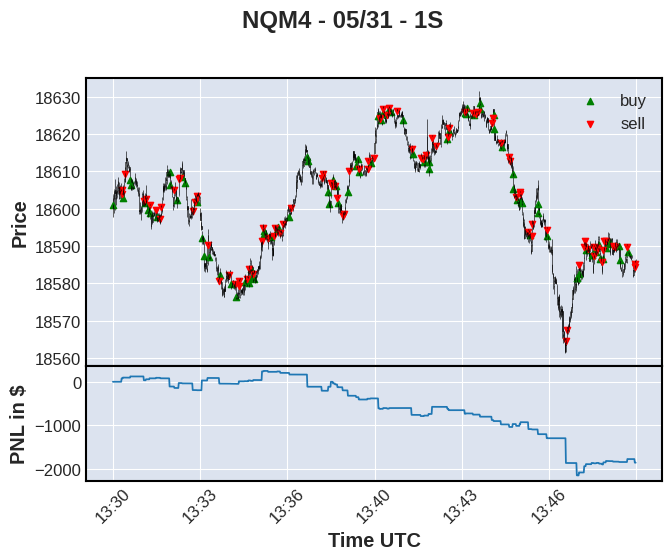

In [14]:
# Cell 4
# Separate the trades dataframe to plot separately (buys and sells)
# Plot the 2 trade dataframes as scatterplots on top of ohlc data
from utils import format_chart_title

trades_df_buys = trades_df.copy()
# Set all rows to NaN where the 'side' is not 'B'
trades_df_buys.loc[trades_df_buys['side'] != 'B'] = np.nan
trades_df_buys_open = trades_df_buys.copy()
trades_df_buys_closed = trades_df_buys.copy()

trades_df_sells = trades_df.copy()
# Set all rows to NaN where the 'side' is not 'B'
trades_df_sells.loc[trades_df_sells['side'] != 'S'] = np.nan
chart_title = format_chart_title(symbols, start_time, chart_schema)
buy_plot = mpf.make_addplot(trades_df_buys['price'], 
                              type='scatter', 
                              markersize=20, 
                              marker='^', 
                              color='g', 
                              label="buy")
sell_plot = mpf.make_addplot(trades_df_sells['price'], 
                              type='scatter', 
                              markersize=20, 
                              marker='v', 
                              color='r', 
                              label="sell")

pnl = mpf.make_addplot(trades_df['total_pnl'],panel=1,type='line',ylabel='PNL in $')
mpf.plot(
    nq_ohlc_df,
    type="candle",
    title=chart_title,
    ylabel="Price",
    xlabel="Time UTC",
    addplot=[buy_plot,sell_plot, pnl],
)

